In [1]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

from vis.visualization import visualize_cam
from vis.utils import utils

import keras

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd 
import time

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
#     config.gpu_options.per_process_gpu_memory_fraction = .7
    return tf.Session(config=config)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


In [2]:
n_model = models.load_model("D:/RetinaNet_Snapshots/Monday_9_10_2018_inital/resnet50_csv_500.h5",
                     backbone_name='resnet50', convert=True)

In [ ]:
n_model.summary()

In [3]:
class_labels = pd.read_csv('U:\\PycharmProjects\\AnimalBiometrics\\data\\annotations\\class_mapping.csv', header=None).to_dict()[0]
label_class = {v: k for k, v in class_labels.items()}

In [4]:
images = []
scales = []
draws = []
labels_test = []
path = 'U:\\PycharmProjects\\AnimalBiometrics\\data\\Clouded_leopard_ID\\test_cleaned_cropped\\'

# load all test images because they are only 114
for subdir, dirs, files in os.walk(path): 
    if dirs == []:
        if len(files) < 0: 
            continue
        for elem in files:
            if elem == 'Thumbs.db': continue
        #     image = read_image_bgr('U:\\PycharmProjects\\AnimalBiometrics\\data\\
        #     Clouded_leopard_ID\\test_cleaned_cropped\\DFR_2_Male\\SDC64__PC071__2014-12-23__04-17-17B.JPG')
            labels_test.append(label_class[subdir[subdir.rfind('\\')+1:]])
            image = read_image_bgr(subdir + '\\' + elem)
            draw = image.copy()
            draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
            draws.append(draw)
            image = preprocess_image(image)
            image, scale = resize_image(image)
            images.append(image)
            scales.append(scale)
        
images = np.array(images)
scales = np.array(scales)
draws = np.array(draws)
labels_test = np.array(labels_test)

In [5]:
start = time.time()
boxes, scores, labels = [], [], []
# boxes, scores, labels = n_model.predict_on_batch(images[:2])
for elem in images:
    b, s, l = n_model.predict_on_batch(np.expand_dims(elem, axis=0))
    boxes.append(b)
    scores.append(s)
    labels.append(l)
    
print("processing time: ", time.time() - start)

boxes = np.squeeze(np.array(boxes), axis=1)
scores = np.squeeze(np.array(scores), axis=1)
labels = np.squeeze(np.array(labels), axis=1)

processing time:  11.830236673355103


In [6]:
print(draw.shape)
print(image.shape)
print(boxes[0].shape)
print(image.shape/scales[0])
print(draw.shape/scales[0])
print(boxes[0].shape/scales[0])

(1441, 2048, 3)
(800, 1137, 3)
(300, 4)
[1441.      2048.02125    5.40375]
[2595.60125 3688.96       5.40375]
[540.375   7.205]


In [19]:
import collections
import itertools

def plot_confusion_matrix(cm, 
                          class_dict,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          font_size = 25):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm[np.isnan(cm)] = 0.
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)
    plt.figure(figsize=(15,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    ordered_classes = collections.OrderedDict(sorted(class_dict.items()))
    tick_marks = np.arange(len(ordered_classes.keys()))
    plt.xticks(tick_marks, ordered_classes.values(), rotation=45, fontsize=font_size)
    plt.yticks(tick_marks, ordered_classes.values(), size=font_size)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    if len(class_dict.keys()) < 10:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",
                     size=font_size-5)

    plt.ylabel('True label', size="large")
    plt.xlabel('Predicted label', size="large")
    plt.tight_layout()
    plt.savefig('conf_mat')


In [8]:
true_names = np.array([class_labels[elem] for elem in labels_test])
prediction_names = np.array([class_labels[elem] for elem in labels[:,0]])

In [9]:
from sklearn.metrics import accuracy_score
accuracy_score(true_names, prediction_names)

0.8596491228070176

Normalized confusion matrix


C:\Users\fotto\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


               precision    recall  f1-score   support

DFR_10_Female       1.00      0.67      0.80         3
DFR_11_Female       0.50      0.67      0.57         3
   DFR_1_Male       1.00      1.00      1.00         5
   DFR_2_Male       0.82      0.95      0.88        19
   DFR_3_Male       0.00      0.00      0.00         1
   DFR_4_Male       1.00      1.00      1.00         3
   DFR_5_Male       0.75      1.00      0.86         3
   DFR_6_Male       0.58      0.78      0.67         9
 DFR_7_Female       1.00      1.00      1.00         4
 DFR_8_Female       1.00      0.75      0.86         4
 DFR_9_Female       1.00      0.67      0.80         3
DFR_Unknown_1       0.00      0.00      0.00         1
DFR_Unknown_2       1.00      1.00      1.00         1
   KFR_1_Male       1.00      0.67      0.80         3
   KFR_2_Male       1.00      1.00      1.00         3
   KFR_3_Male       1.00      0.75      0.86         4
   KFR_4_Male       1.00      1.00      1.00         3
   KFR_5_

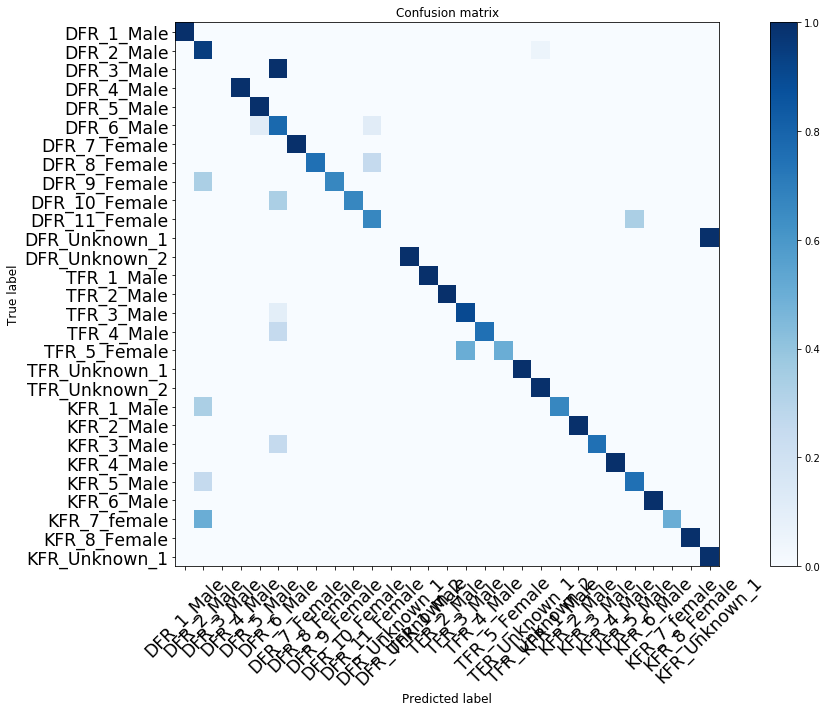

In [10]:
from sklearn.metrics import confusion_matrix, classification_report

cnf_matrix = confusion_matrix(true_names, prediction_names, labels=list(class_labels.values()))
cnf_matrix[np.isnan(cnf_matrix)] = 0

plot_confusion_matrix(cnf_matrix, class_dict=class_labels, title='Confusion matrix',normalize=True)
print(classification_report(true_names, prediction_names))

In [11]:
def get_data_dist(img_path="U:/PycharmProjects/AnimalBiometrics/data/Clouded_leopard_ID/train_cleaned_cropped"):
    res = {}
    for subdir, dirs, files in os.walk(img_path):
#         if 'coarse' not in subdir.lower():
#             continue
        if dirs == []:
            idx = subdir.rfind("\\")+1
            res[subdir[idx:]]=len(files)    
            
    return res

In [12]:
def simplify_labels(true, pred, count_dict):
    true_copy = np.copy(true)
    pred_copy = np.copy(pred)
    class_dict= {}
    class_count = collections.defaultdict(int)
        
    for animal, count in count_dict.items():
            
        label_idx = (true_copy == animal).nonzero()[0]
        pred_idx = (pred_copy == animal).nonzero()[0]

        if count >= 15:
            top_level = 'Scarce >=15'
            key = 1
        elif count >= 10:
            top_level = 'Rare >=10'
            key = 2
        elif count >= 5:
            top_level = 'Very Rare >=5'
            key = 3
        else:
            top_level = 'Extremely Rare <5'
            key = 4
            
        if key not in class_dict.keys():
            class_dict[key] = top_level
        class_count[key] += 1
        
        true_copy[label_idx] = top_level
        pred_copy[pred_idx] = top_level
    print(class_count)
    return true_copy, pred_copy, class_dict

In [13]:
import collections

dist_res = get_data_dist("U:/PycharmProjects/AnimalBiometrics/data/Clouded_leopard_ID/train_cleaned_cropped")
res = collections.OrderedDict(sorted(dist_res.items()))

In [27]:
import matplotlib

plt.figure(0, figsize=(15,20))
plt.barh(list(res.keys()), list(res.values()))
# plt.xticks(rotation='vertical')
plt.vlines(15, -1, 29, label='Scarce')
plt.vlines(10, -1, 29, label='Rare')
plt.vlines(5, -1, 29, label='Very Rare')
# plt.ylim(ymax=1000)
# plt.legend()

sorted_res_value = collections.OrderedDict(sorted(res.items(), key=lambda kv: kv[1]))

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

plt.figure(1, figsize=(15,20))
plt.barh(list(sorted_res_value.keys()), list(sorted_res_value.values()))
# plt.xticks(rotation='vertical')
# plt.ylim(ymax=1000)
# plt.vlines(15, -1, 29, label='Scarce')
# plt.vlines(10, -1, 29, label='Rare')
# plt.vlines(5, -1, 29, label='Very Rare')
# plt.legend()

In [15]:
data_array_names_simple, prediction_heat_names_simple, class_dict_simple = simplify_labels(true_names, prediction_names, res)

defaultdict(<class 'int'>, {1: 6, 2: 8, 3: 9, 4: 6})


In [28]:
cnf_matrix = confusion_matrix(data_array_names_simple, prediction_heat_names_simple, labels=list(class_dict_simple.values()))
cnf_matrix[np.isnan(cnf_matrix)] = 0
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, class_dict=class_dict_simple, title='Confusion matrix',normalize=True)
print(classification_report(data_array_names_simple, prediction_heat_names_simple))

In [44]:
# correct for image scale
boxes /= np.array(scales)[:, None, None]

In [42]:
def add_detections_to_images(boxes, scores, labels, visualize=False):
    total = len(labels)
    for i, (box2, score2, label2) in enumerate(zip(boxes, scores, labels)):
    #     for box, score, label in zip(box2, score2, label2):

        box, score, label = box2[0], score2[0], label2[0]

        # scores are sorted so we can break
    #     if score < 0.05:
    #         break

        color = label_color(label)

        box = box.astype(int)
        draw_box(draws[i], box, color=color)

        caption = "{} {:.3f}".format(class_labels[label], score)
    #     draw_caption(draw, b, caption)
        b = np.array(box).astype(int)
        cv2.putText(draws[i], caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 4, (0, 0, 0), 2)
        cv2.putText(draws[i], caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 4, (255, 255, 255), 2)
        
        if visualize:
            print(label, caption)
            plt.figure(figsize=(15, 15))
            plt.axis('off')
            plt.imshow(draws[i])
            plt.show()
        print('Image {}/{}'.format(i+1, total))

In [43]:
add_detections_to_images(boxes, scores, labels, visualize=False)

Image 1/114
Image 2/114
Image 3/114
Image 4/114
Image 5/114
Image 6/114
Image 7/114
Image 8/114
Image 9/114
Image 10/114
Image 11/114
Image 12/114
Image 13/114
Image 14/114
Image 15/114
Image 16/114
Image 17/114
Image 18/114
Image 19/114
Image 20/114
Image 21/114
Image 22/114
Image 23/114
Image 24/114
Image 25/114
Image 26/114
Image 27/114
Image 28/114
Image 29/114
Image 30/114
Image 31/114
Image 32/114
Image 33/114
Image 34/114
Image 35/114
Image 36/114
Image 37/114
Image 38/114
Image 39/114
Image 40/114
Image 41/114
Image 42/114
Image 43/114
Image 44/114
Image 45/114
Image 46/114
Image 47/114
Image 48/114
Image 49/114
Image 50/114
Image 51/114
Image 52/114
Image 53/114
Image 54/114
Image 55/114
Image 56/114
Image 57/114
Image 58/114
Image 59/114
Image 60/114
Image 61/114
Image 62/114
Image 63/114
Image 64/114
Image 65/114
Image 66/114
Image 67/114
Image 68/114
Image 69/114
Image 70/114
Image 71/114
Image 72/114
Image 73/114
Image 74/114
Image 75/114
Image 76/114
Image 77/114
Image 78

In [44]:
import scipy.ndimage as ndimage
from vis.visualization import visualize_saliency
import matplotlib.gridspec as gridspec

def compute_saliency_map(model, array, target_class, layer_idx=-1):
    grads = visualize_saliency(model, layer_idx, filter_indices=target_class, seed_input=array)
    return ndimage.gaussian_filter(grads, sigma=5) 

def render_img_on_grid(img, pos, grid):
    ax = plt.subplot(grid[pos])
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

def show_side_by_side(img, saliency_map, pred, true):
    img = cv2.resize(img, (saliency_map.shape[1],saliency_map.shape[0]))
    fig = plt.figure(figsize=(20,10))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    grid = gridspec.GridSpec(1, 2, wspace=0.)
    render_img_on_grid(img, 0, grid)
    text = 'True: ' + true
    plt.title(text, size="xx-large")
    ax = render_img_on_grid(img, 1, grid)
    ax.imshow(saliency_map, alpha=.7)
    text = 'Pred: ' + pred
    ax.set_title(text, size="xx-large")
    plt.show()
    plt.close(fig)

In [45]:
from matplotlib.pyplot import imshow
def print_comparison_v2(indices, images, predictions, labels, trained_model, draws, activation_layer='predictions'):
    
#     trained_model.layers[utils.find_layer_idx(trained_model, "predictions")].activation = keras.activations.linear
    
    for i, img_number in enumerate(indices):
        saliency_map = compute_saliency_map(trained_model, array=images[img_number],
                                            target_class=[labels[img_number]], 
                                            layer_idx=utils.find_layer_idx(trained_model, activation_layer))
        show_side_by_side(draws[img_number], saliency_map, class_labels[predictions[img_number]], 
                          class_labels[labels[img_number]])

In [46]:
correct_pred = (prediction_names == true_names).nonzero()[0]
wrong_pred = (prediction_names != true_names).nonzero()[0]

In [29]:
print_comparison_v2(wrong_pred, images, labels[:,0], labels_test, n_model, draws, 'classification')

In [30]:
print_comparison_v2(correct_pred, images, labels[:,0], labels_test, n_model, draws, 'classification')